In [32]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../../src/")
from utils import read_xray
import matplotlib.patches as ptc
from tqdm.notebook import tqdm

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [82]:
path2labels_train = "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_train.csv"
bbox_train = pd.read_csv(path2labels_train)
path2labels_test = "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_test.csv"
bbox_test = pd.read_csv(path2labels_test)

labels = ['Aortic enlargement', 'Atelectasis','Calcification', 'Cardiomegaly', 'Consolidation','ILD', 'Infiltration','Lung Opacity','Nodule/Mass','Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
       'Pulmonary fibrosis', 'No finding']
label_idx = list(range(0,len(labels)))
label_dict = dict(zip(labels, label_idx))

#Training Set
#Removing other than 14 classes
for i in tqdm(bbox_train.index):
    try:
        bbox_train.loc[i, 'class_id'] = label_dict[bbox_train.loc[i]['class_name']]
    except:
        bbox_train.drop(i, inplace = True)
bbox_train.set_index('image_id', inplace=True)

#Testing Set
#Removing other than 14 classes
for i in tqdm(bbox_test.index):
    try:
        bbox_test.loc[i, 'class_id'] = label_dict[bbox_test.loc[i]['class_name']]
    except:
        bbox_test.drop(i, inplace = True)
bbox_test.set_index('image_id', inplace=True)

In [89]:
def resize_bbox(img_name, bboxes, h, w, data_type = 'train'):
    img_arr = read_xray(f"/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/{data_type}/{img_name}.dicom")
    x_scale = w/img_arr.shape[1]
    y_scale = h/img_arr.shape[0]
    return bboxes*[x_scale,y_scale,x_scale,y_scale] 

In [54]:
#Training set
# Resizing to 256x256 
for i in tqdm(np.unique(bbox_train.index)):
    transformed_dict = resize_bbox(i,bbox_train.loc[i,['x_min','y_min', 'x_max', 'y_max']].values, 256,256, 'train')
    bbox_train.loc[i, ['x_min','y_min', 'x_max', 'y_max']] = np.array(transformed_dict)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [59]:
bbox_train.to_csv("./bboxes/train_bbox.csv")

In [90]:
#Testing set
# Resizing to 256x256 
for i in tqdm(np.unique(bbox_test.index)):
    transformed_dict = resize_bbox(i,bbox_test.loc[i,['x_min','y_min', 'x_max', 'y_max']].values, 256,256, 'test')
    bbox_test.loc[i, ['x_min','y_min', 'x_max', 'y_max']] = np.array(transformed_dict)

  0%|          | 0/2997 [00:00<?, ?it/s]

In [93]:
bbox_test.to_csv("./bboxes/test_bbox.csv")

In [120]:
cols = ['#e41a1c', '#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#000000', '#1b9e77', '#d95f02', '#7570b3', '#e7298a']
def view_with_annot(image_name, train_csv, data_type = 'train'):
    img = Image.open(f"/scratch/scratch6/akansh12/DeepEXrays/data/data_256/{data_type}/{image_name}.png")
    fig, ax = plt.subplots(1, figsize = (6,6))
    ax.imshow(img, cmap = 'gray')
    for i in range(0,len(train_csv[train_csv['image_id']==image_name])):
        rect = ptc.Rectangle((train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                              train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i]), 
                             train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_max[i]-train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                             train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_max[i]-train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i], 
                             linewidth = 1, edgecolor = cols[i], facecolor = 'none')
        ax.add_patch(rect)
        ax.annotate(train_csv[train_csv['image_id']==image_name].reset_index(drop = True).class_name[i],
                    (train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                    train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i] - 24) )

### Raw annotations

#### Train Set

In [103]:
bbox_train = pd.read_csv("./bboxes/train_bbox.csv")

In [101]:
rnd_train_img = np.random.choice(np.unique(bbox_train.image_id), 4)

In [109]:
bbox_train.set_index('image_id').loc[rnd_train_img[3]]

,rad_id,class_name,x_min,y_min,x_max,y_max,class_id
image_id,,,,,,,
db7da50ba329b52f6779db53689c289f,R10,Aortic enlargement,124.752091,72.177801,155.817428,118.558298,0.0
db7da50ba329b52f6779db53689c289f,R8,Aortic enlargement,124.559505,73.797676,154.508273,106.644107,0.0
db7da50ba329b52f6779db53689c289f,R9,Aortic enlargement,120.504250,73.224338,155.172107,107.874980,0.0


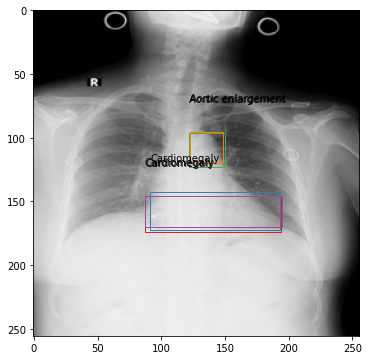

In [121]:
view_with_annot(rnd_train_img[0], bbox_train)

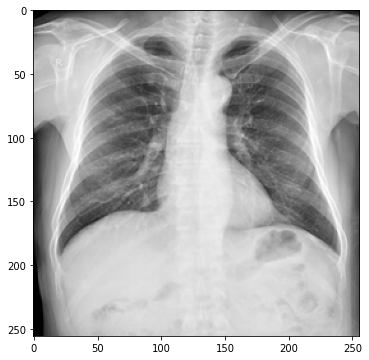

In [117]:
view_with_annot(rnd_train_img[1], bbox_train)

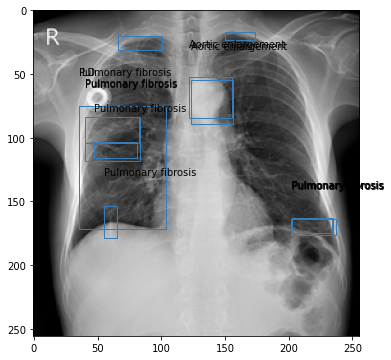

In [118]:
view_with_annot(rnd_train_img[2], bbox_train)

#### Test Set

In [122]:
bbox_test = pd.read_csv("./bboxes/test_bbox.csv")

In [134]:
rnd_test_img = np.random.choice(np.unique(bbox_test.image_id), 4)

In [135]:
bbox_test.set_index('image_id').loc[rnd_test_img[3]]

,class_name,x_min,y_min,x_max,y_max,class_id
image_id,,,,,,
d5929a39b7527fc0e78f80b8a15f3a0f,Pleural thickening,118.606058,40.889628,133.576698,46.454472,11.0
d5929a39b7527fc0e78f80b8a15f3a0f,Pleural thickening,58.269842,40.163779,82.464816,46.575447,11.0
d5929a39b7527fc0e78f80b8a15f3a0f,Pulmonary fibrosis,23.187129,61.939255,48.591852,93.755646,13.0
d5929a39b7527fc0e78f80b8a15f3a0f,Calcification,26.513938,65.084602,44.508950,89.279576,2.0
d5929a39b7527fc0e78f80b8a15f3a0f,Pulmonary fibrosis,50.482361,48.012689,82.695377,80.668327,13.0


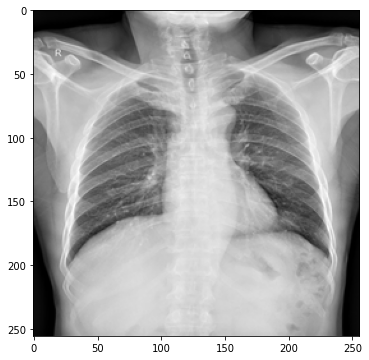

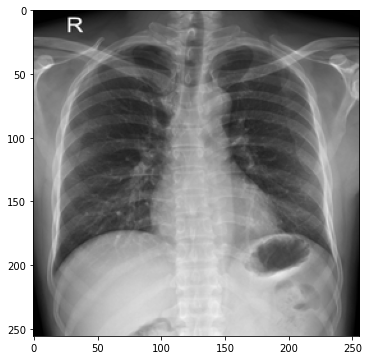

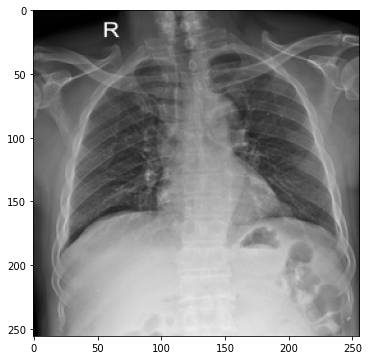

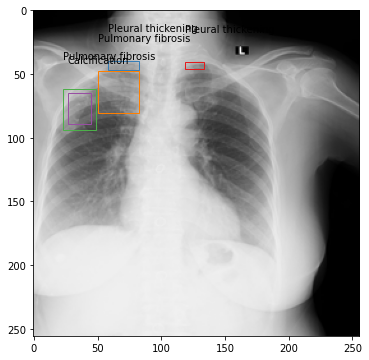

In [137]:
for i in rnd_test_img:
    view_with_annot(i, bbox_test, data_type='test')

### Fusing BBoxes

#### WBF

In [145]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
sns.set(rc={"font.size":9,"axes.titlesize":15,"axes.labelsize":9,
            "axes.titlepad":11, "axes.labelpad":9, "legend.fontsize":7,
            "legend.title_fontsize":7, 'axes.grid' : False})
import cv2
import json
import pandas as pd
import glob
import os.path as osp
from path import Path
import datetime
import numpy as np
from tqdm.auto import tqdm
import random
import shutil
from sklearn.model_selection import train_test_split

from ensemble_boxes import *
import warnings
from collections import Counter

In [153]:
def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap='gray', img_size=None):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    
def draw_bbox(image, box, label, color):   
    alpha = 0.1
    alpha_box = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_box, output, 1 - alpha_box, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return output


In [ ]:
boxes, scores, box_labels= weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights,
                                                     iou_thr=iou_thr, skip_box_thr=skip_box_thr)

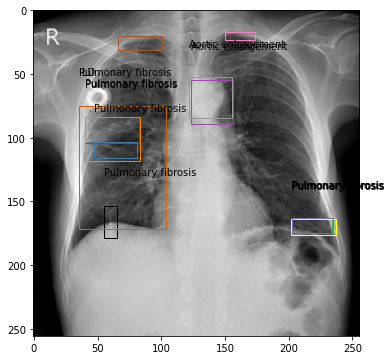

In [140]:
view_with_annot(rnd_train_img[2], bbox_train)

In [266]:
def wbf(image_name, bbox_train):
    
    img_array  = cv2.imread(f"/scratch/scratch6/akansh12/DeepEXrays/data/data_256/train/{image_name}.png")
    img_annotations = bbox_train[bbox_train.image_id==image_name]
    
    
    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
    
    
    
    for cid in cls_ids:       
    ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)
        
    boxes, scores, box_labels= weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights,
                                                     iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    
    return boxes, box_labels

In [313]:
new_wbf_bbox_train = pd.DataFrame(columns=np.delete(bbox_train.columns.values,1 ))

In [314]:
new_wbf_bbox_train

,image_id,class_name,x_min,y_min,x_max,y_max,class_id


In [321]:
j = 0
for i in tqdm(np.unique(bbox_train['image_id'])):
    
    for m,k in enumerate(wbf(i, bbox_train)[0]):
        new_wbf_bbox_train.loc[j, 'image_id'] = i
        new_wbf_bbox_train.loc[j, ['x_min', 'y_min', 'x_max', 'y_max']] = k
        new_wbf_bbox_train.loc[j, ['class_id']] = wbf(i, bbox_train)[1][m]
        new_wbf_bbox_train.loc[j, ['class_name']] = labels[int(wbf(i, bbox_train)[1][m])]
        j = j+1

  0%|          | 0/15000 [00:00<?, ?it/s]

In [324]:
new_wbf_bbox_train.head(15)

,image_id,class_name,x_min,y_min,x_max,y_max,class_id
0,000434271f63a053c4128a0ba6352c7f,No finding,NaN,NaN,NaN,NaN,14
1,000434271f63a053c4128a0ba6352c7f,No finding,NaN,NaN,NaN,NaN,14
2,000434271f63a053c4128a0ba6352c7f,No finding,NaN,NaN,NaN,NaN,14
3,00053190460d56c53cc3e57321387478,No finding,NaN,NaN,NaN,NaN,14
4,00053190460d56c53cc3e57321387478,No finding,NaN,NaN,NaN,NaN,14
5,00053190460d56c53cc3e57321387478,No finding,NaN,NaN,NaN,NaN,14
6,0005e8e3701dfb1dd93d53e2ff537b6e,Lung Opacity,75.3,48.8,100.4,74.1,7
7,0005e8e3701dfb1dd93d53e2ff537b6e,Infiltration,75.079748,48.984085,100.446665,74.05925,6.0
8,0005e8e3701dfb1dd93d53e2ff537b6e,Consolidation,77.705999,47.314916,99.814168,74.70075,4.0
9,0005e8e3701dfb1dd93d53e2ff537b6e,Nodule/Mass,77.705999,47.314916,99.814168,74.70075,8.0


In [325]:
new_wbf_bbox_train.to_csv("./bboxes/wbf_bbox_train.csv")

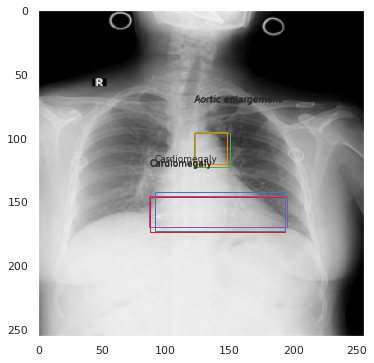

In [327]:
view_with_annot(rnd_train_img[1], bbox_train)

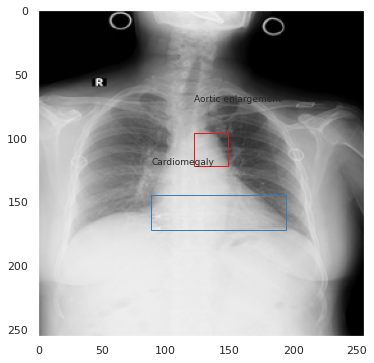

In [328]:
view_with_annot(rnd_train_img[1], new_wbf_bbox_train)

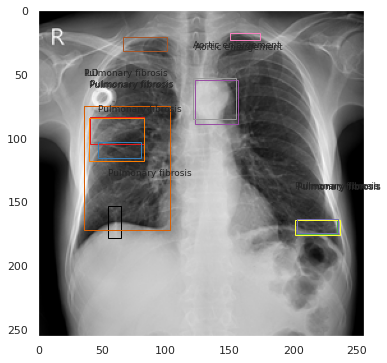

In [329]:
view_with_annot(rnd_train_img[0], bbox_train)

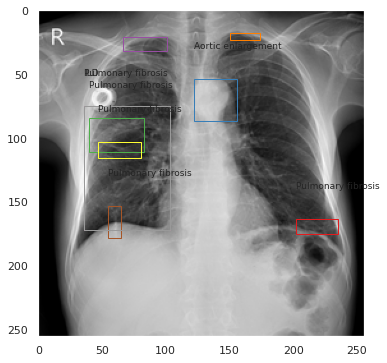

In [331]:
view_with_annot(rnd_train_img[0], new_wbf_bbox_train)